In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [239]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data('./mnist.npz')

# Create Dataset and Dataloader

In [429]:
# ONE SAMPLE X_TRAIN

x_train = x_train[0:2]
x_test = x_test[0:2]

In [356]:
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0

# # Unsqueeze to add channel dimension
# x_train_normalized = np.expand_dims(x_train_normalized, axis=1)
# x_test_normalized = np.expand_dims(x_test_normalized, axis=1)


# Create a x_in with shape 1 1 28 28 with all 0.2s
x_in1 = np.full((1, 28, 28), 0.5)
x_in2 = np.full((1, 28, 28), 0.0)
x_in = np.concatenate((x_in1, x_in2), axis=0)


# Convert to tensors
train_dataset = TensorDataset(torch.tensor(x_in).float(), torch.tensor(x_train_normalized).float())
validat_dataset = TensorDataset(torch.tensor(x_test_normalized).float(), torch.tensor(x_test_normalized).float())

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validat_loader = DataLoader(validat_dataset, batch_size=1, shuffle=False)

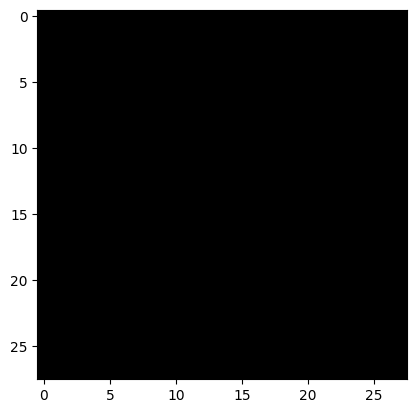

In [348]:
# plot an image
plt.imshow(x_in[0][0], cmap='gray')

# Model Architecture

In [210]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, encoding_dim=32):
        super(SimpleAutoencoder, self).__init__()
        self.encoding_dim = encoding_dim
        
        # Encoder: Flattens the input and applies a linear transformation
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the 28x28 input image
            nn.Linear(28*28, encoding_dim),  # Linear layer to reduce dimension to encoding_dim
            nn.ReLU(True)  # Activation function
        )
        
        # Decoder: Applies a linear transformation and reshapes to original dimensions
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 28*28),  # Linear layer to reconstruct the original image
            nn.Sigmoid(),  # Activation function
            nn.Unflatten(1, (28, 28))  # Reshape output to 28x28
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [349]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Keeps spatial dimensions the same with padding=1
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2, padding=1),  # No padding needed here, output will be halved
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2, padding=1),  # Output spatial dimensions halved
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)  # Output: (batch, 8, 4, 4)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Scales dimensions up by 2
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 16, kernel_size=3, padding=0),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output should match input dimensions and be between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [365]:
# summary of SimpleAutoencoder with torchsummary
import torchinfo
model = SimpleAutoencoder()
torchinfo.summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleAutoencoder                        [1, 28, 28]               --
├─Sequential: 1-1                        [1, 32]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 32]                   25,120
│    └─ReLU: 2-3                         [1, 32]                   --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─Linear: 2-4                       [1, 784]                  25,872
│    └─Sigmoid: 2-5                      [1, 784]                  --
│    └─Unflatten: 2-6                    [1, 28, 28]               --
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21

# Training

In [375]:
def l1_regularization(model, lambda_reg):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_reg * l1_norm


def r2_score(y_pred, y_true):
    """R2 score"""
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot


def train_one_epoch(model, train_loader, loss_func, optimizer, lambda_reg):
    
    model.train()
    epoch_loss = 0
    epoch_r2 = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input, target = batch
        prediction = model(input)
        loss = loss_func(prediction, target)
        loss += l1_regularization(model, lambda_reg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        r2 = r2_score(prediction, target).item()
        if r2 > 0:
            epoch_r2 += r2

    return epoch_loss / len(train_loader), epoch_r2 / len(train_loader)


def validate_one_epoch(model, validation_loader, loss_func, lambda_reg):

    model.eval()
    epoch_loss = 0
    epoch_r2 = 0

    with torch.no_grad():
        for batch in validation_loader:
            input, target = batch
            prediction = model(input)
            loss = loss_func(prediction, target)
            loss += l1_regularization(model, lambda_reg)
            epoch_loss += loss.item()

            r2 = r2_score(prediction, target).item()
            if r2 > 0:
                epoch_r2 += r2

    return epoch_loss / len(validation_loader), epoch_r2 / len(validation_loader)
        

def train_model(model, train_loader, validation_loader, loss_func, optimizer, epochs, lambda_reg=0):

    plot = PlotLosses()

    for epoch in range(epochs):
        train_epoch_loss, train_epoch_r2 = train_one_epoch(model, train_loader, loss_func, optimizer, lambda_reg)
        validation_epoch_loss, validate_epoch_r2 = validate_one_epoch(model, validation_loader, loss_func, lambda_reg)

        logs = {
            'acc': train_epoch_r2,
            'val_acc': validate_epoch_r2,
            'loss': train_epoch_loss,
            'val_loss': validation_epoch_loss,
        }

        plot.update(logs)
        plot.send()

        print(f'Epoch: {epoch}, Loss: {train_epoch_loss}, Validation Loss: {validation_epoch_loss}')

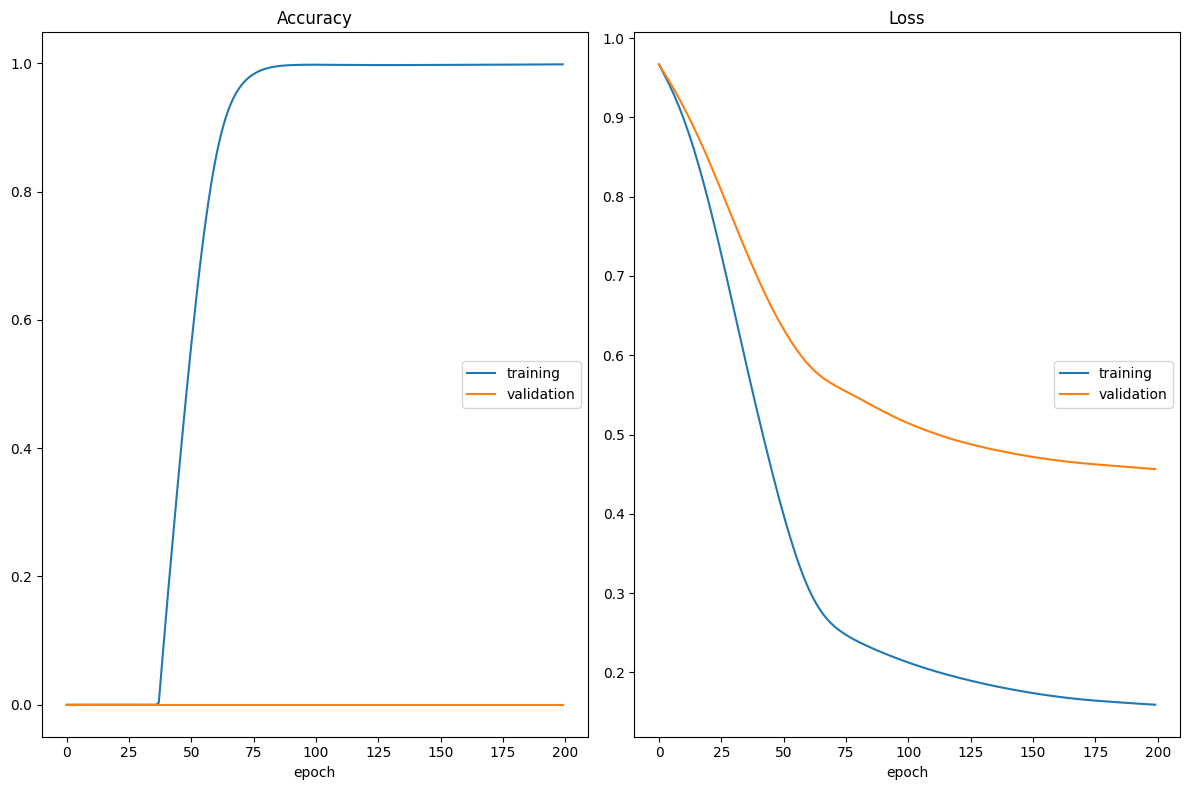

Accuracy
	training         	 (min:    0.000, max:    0.998, cur:    0.998)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.159, max:    0.967, cur:    0.159)
	validation       	 (min:    0.456, max:    0.967, cur:    0.456)
Epoch: 199, Loss: 0.15929681062698364, Validation Loss: 0.4564557373523712


In [419]:
autoencoder = SimpleAutoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
loss_func = nn.BCELoss()

train_model(autoencoder, train_loader, validat_loader, loss_func, optimizer, epochs=200, lambda_reg=0.0001)

In [422]:
# max of autoencoder parameters
max_weight = torch.max(autoencoder.encoder[1].weight)
print(f'max: {max_weight}')

# min
min_weight = torch.min(autoencoder.encoder[1].weight)
print(f'min: {min_weight}')

# median
median_weight = torch.median(autoencoder.encoder[1].weight)
print(f'median: {median_weight}')

# mean
mean_weight = torch.mean(autoencoder.encoder[1].weight)
print(f'mean: {mean_weight}')

# zero
zero_count = torch.sum(autoencoder.encoder[1].weight == 0)
print(f'zero: {zero_count}')

# how many smaller than 1e-5
small_count = torch.sum(autoencoder.encoder[1].weight < 1e-5)
print(f'smaller than 1e-5: {small_count}')

# how many in total
total_count = autoencoder.encoder[1].weight.numel()
print(f'total: {total_count}')

max: 0.10620085150003433
min: -0.0007281482103280723
median: 9.190950368065387e-05
mean: 0.014329290948808193
zero: 0
smaller than 1e-5: 8881
total: 25088


In [ ]:
# max of autoencoder parameters
max_weight = torch.max(autoencoder.encoder[1].weight)
print(f'max: {max_weight}')

# min
min_weight = torch.min(autoencoder.encoder[1].weight)
print(f'min: {min_weight}')

# median
median_weight = torch.median(autoencoder.encoder[1].weight)
print(f'median: {median_weight}')

# mean
mean_weight = torch.mean(autoencoder.encoder[1].weight)
print(f'mean: {mean_weight}')

# zero
zero_count = torch.sum(autoencoder.encoder[1].weight == 0)
print(f'zero: {zero_count}')

# how many smaller than 1e-5
small_count = torch.sum(autoencoder.encoder[1].weight < 1e-5)
print(f'smaller than 1e-5: {small_count}')

# how many in total
total_count = autoencoder.encoder[1].weight.numel()
print(f'total: {total_count}')

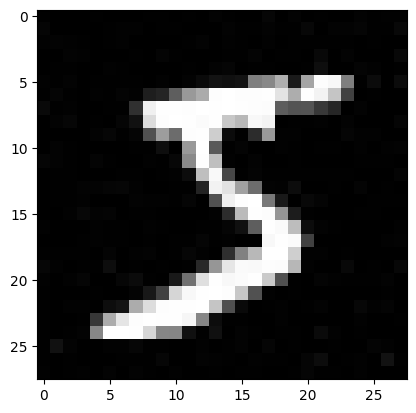

In [423]:
# plot one image
reconstructed = autoencoder(train_dataset[0][0].unsqueeze(0))
plt.imshow(reconstructed.detach().numpy().squeeze(), cmap='gray')

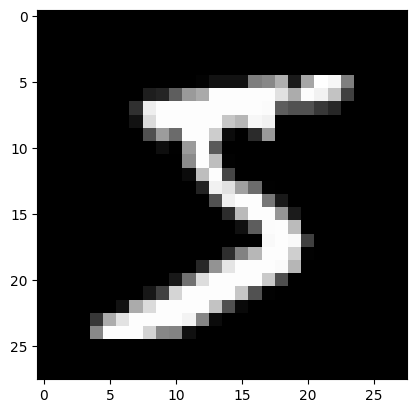

In [363]:
# plot the original image
plt.imshow(train_dataset[0][1].squeeze(), cmap='gray')

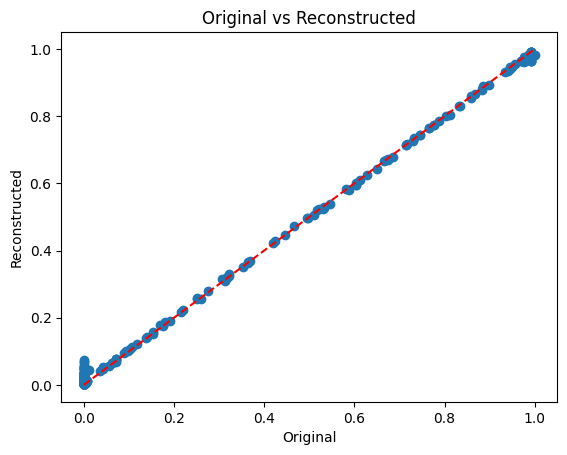

In [424]:
# plot 2d scatter prediction vs target for one image
x = train_dataset[0][0].unsqueeze(0)
y = train_dataset[0][1].unsqueeze(0)
prediction = autoencoder(x)
plt.scatter(y.detach().numpy().squeeze(), prediction.detach().numpy().squeeze())
plt.xlabel('Original')
plt.ylabel('Reconstructed')
plt.title('Original vs Reconstructed')
# plot identity line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
